* Add photo header *

## Business Understanding

In this project, we are exploring how home sale prices in King County are affected by the different features of the house, such as size, number of bedrooms and bathrooms, location, etc. Specifically, we have been hired by a real estate company in King County to build a model that predicts housing prices. Our goal is to determine which features of a home for sale are most important in determining its prices.

## Data Understanding

Import necessary libraries for cleaning and plotting data.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

Load the raw dataset and explore the data.

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# investigate top values for each column.

for col in df.columns:
    print(col)
    print(df[col].value_counts().head())
    print('\n')
        

id
795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


date
6/23/2014    142
6/26/2014    131
6/25/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64


price
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
Name: price, dtype: int64


bedrooms
3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
Name: bathrooms, dtype: int64


sqft_living
1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot
5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: int64


floors
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
Name: floors, dtype: int64


waterfront
0.0    19075
1.0      146
Name: waterfront, dtype: int64


view
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Our dataset contains approximately 21,600 rows. There are some missing values that will need to be handled for 'waterfront', 'view', and 'yr_renovated'. In terms of datatypes, date will need to be converted to a date datatype and 'sqft_basement' will need to change to a float datatype.

Price is going to be our dependent variable. Let's look at the distribution of our variables.

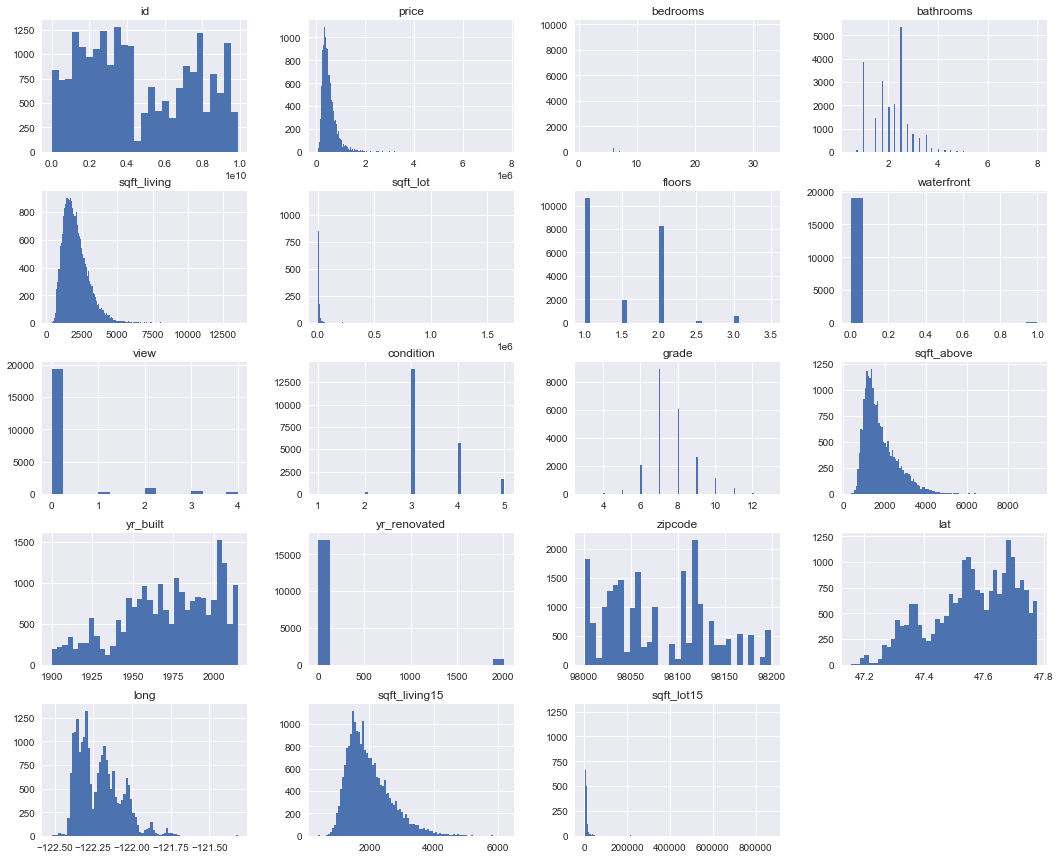

In [6]:
df.hist(figsize=(18,15), bins = 'auto');

It looks like our dependent variable, price, is skewed to the right, as are the bedrooms and square footage columns. Let's make a note to remove outliers for price, and see if it helps remove outliers in some of the other skewed columns.

Two of our columns are longitude and latitude. This should help us create a scatter plot that looks like a map of our data--using price as hue, we can get a quick look at where the most expensive houses are located.

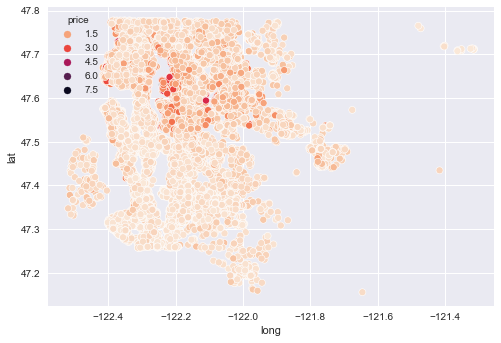

In [7]:
sns.scatterplot(data=df, x="long", y="lat", hue="price", palette = "rocket_r");

We also have zipcode available to us. It may be helpful to convert the zipcodes into bins to easily see if location has an effect on price.

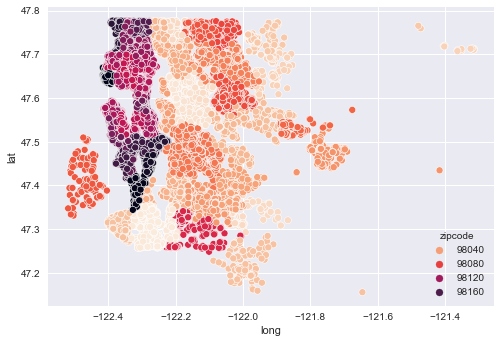

In [8]:
sns.scatterplot(data=df, x="long", y="lat", hue="zipcode", palette = "rocket_r");

Let's also check if any of our features are correlated with each other, which could be problematic for our model.

In [9]:
df_pairs=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_pairs['pairs'] = list(zip(df_pairs.level_0, df_pairs.level_1))

# set index to pairs
df_pairs.set_index(['pairs'], inplace = True)

#d rop level columns
df_pairs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_pairs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_pairs.drop_duplicates(inplace=True)

In [10]:
df_pairs[(df_pairs.cc>.75) & (df_pairs.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


Based on this, it may make sense to drop sqft_living or sq_ft_above, since the two variable are highly correlated.

Lastly, let's check the linearity of each feature by viewing scatter plots.

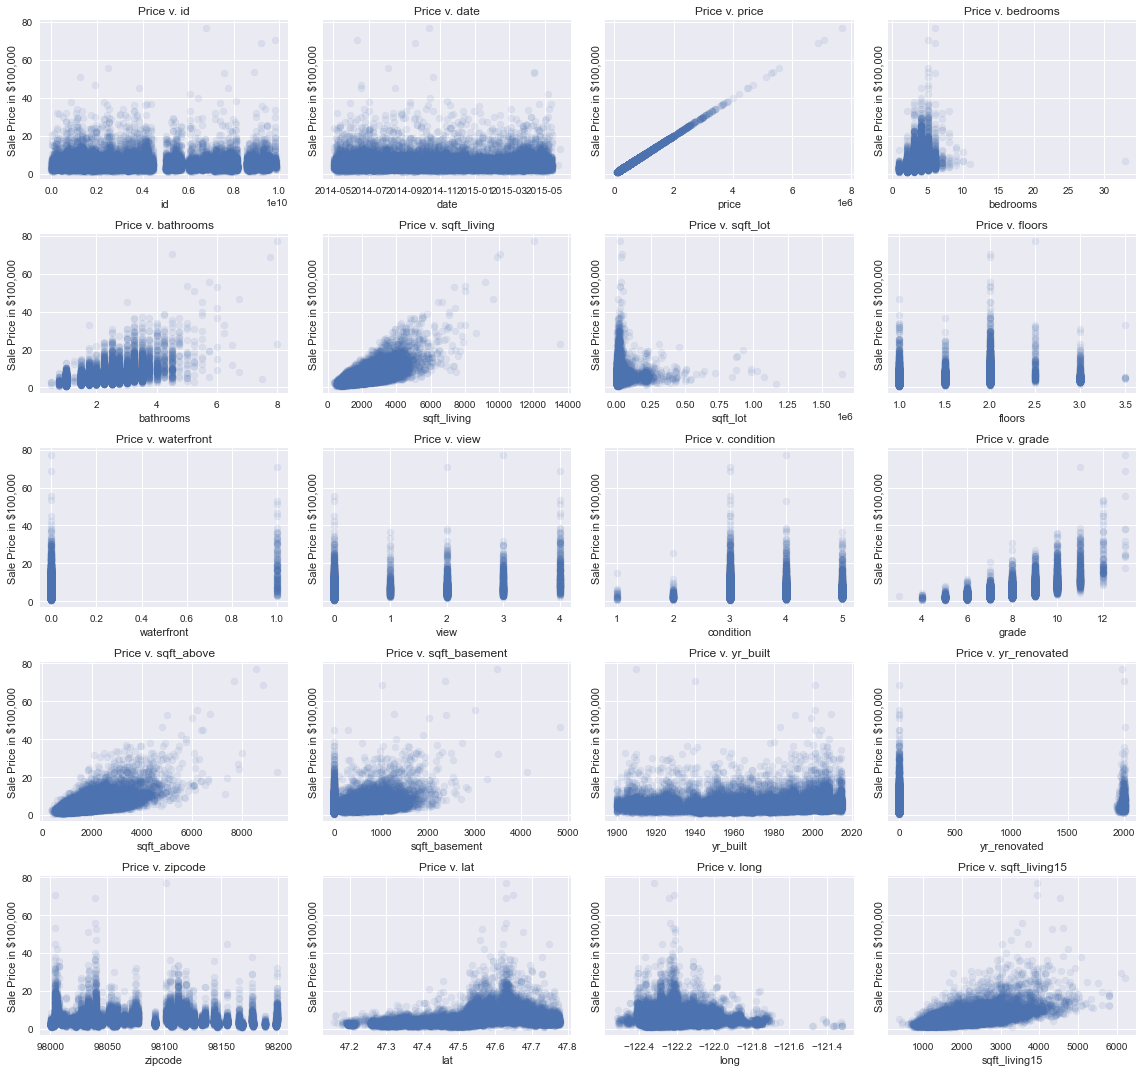

In [23]:
# Your code here 
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), df.columns):
    ax.scatter(df[column], df['price'] / 100000, label=column, alpha=.1)
    ax.set_title(f'Price v. {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

Looking at these scatter plots, there may be a linear relationship with price and:
 * bathrooms
 * potentially bedrooms, but will need to take a closer look
 * sqft_living
 * grade
 * sqft_above
 * sqft_living15

## Data Preparation

### Converting Datatypes

Let's inspect the sqft_basement values and see if this data type should be changed.

In [11]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
225.0         1
2196.0        1
508.0         1
2050.0        1
1930.0        1
Name: sqft_basement, Length: 304, dtype: int64

First, let's convert all '?' values to zero.

In [12]:
df.sqft_basement.replace('?',0.0, inplace=True)

In [13]:
df.sqft_basement.value_counts()

0.0       12826
0.0         454
600.0       217
500.0       209
700.0       208
          ...  
1135.0        1
506.0         1
2360.0        1
1852.0        1
2120.0        1
Name: sqft_basement, Length: 304, dtype: int64

Convert datatype to float.

In [14]:
df.sqft_basement = df.sqft_basement.map(lambda x: float(x))

In [15]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [16]:
# check that sqft_basement is now a float object.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Next, let's convert the date column to a datetime format.

In [17]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
# Confirm the datatype for date changed.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

### Handling Missing Values

Now, let's inspect and handle the missing values in our data.

In [20]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [21]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,285.716581,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,439.819830,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Looking at the waterfront, view and yr_renovated columns, the median values are 0 for all three columns. We think it is safe to assume these missing values can also be filled in with the median values of 0.

In [22]:
for col in df.columns:
    try:
        median = df[col].median()
        df[col] = df[col].fillna(value=median)
    except:
        continue

#recheck missing values and confirm none left.        
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Removing Outliers

Since our dependent variable is price, let's take a closer look at the distribution of this column and check for outliers.

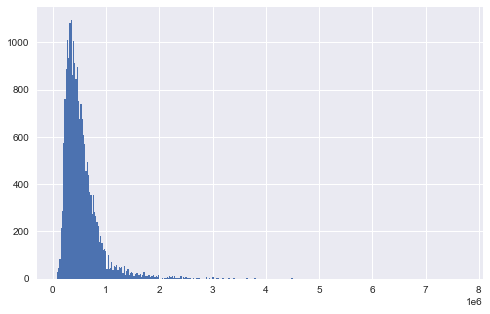

In [24]:
df.price.hist(bins='auto', figsize = (8,5));

In [25]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

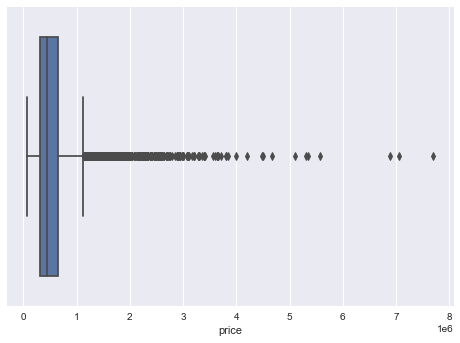

In [26]:
sns.boxplot(x=df['price'])

In [27]:
import scipy.stats as stats

z = np.abs(stats.zscore(df.price))
print(z)

[0.86671627 0.00625157 0.98077344 ... 0.37618606 0.38190525 0.58606486]


In [28]:
df_new = df[(z<3)]
df_new

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [29]:
df.shape

(21597, 21)

In [30]:
df_new.shape

(21191, 21)

We lost about 400 values by removing the price outliers outside of 3 standard deviations from the mean.

<AxesSubplot:xlabel='price'>

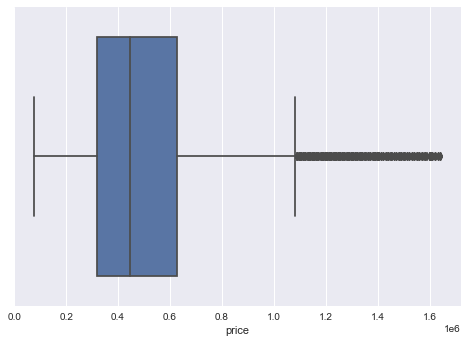

In [31]:
# check boxplot of new dataframe with outliers removed.

sns.boxplot(x=df_new['price'])

### Separate Variables into Continuous and Categorical

Now, let's return to the histograms for all columns and inspect the distribution of the data and whether or not the variables are continuous or categorical.

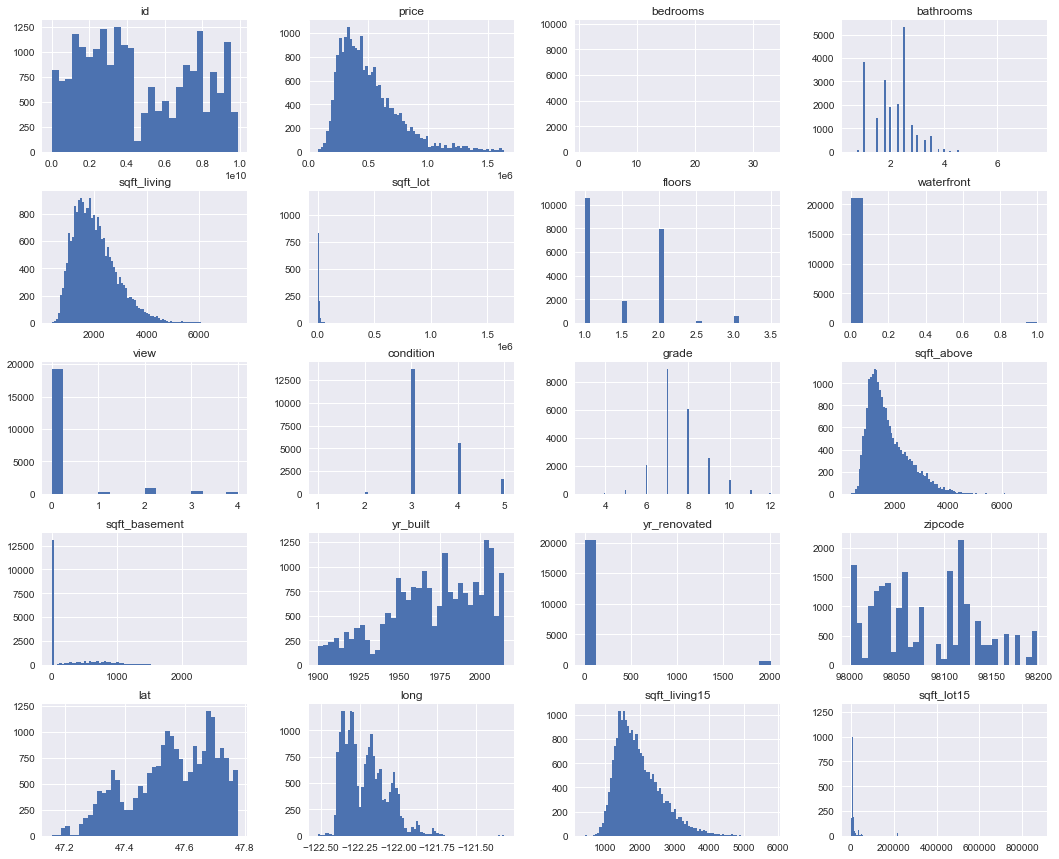

In [32]:
df_new.hist(figsize=(18,15), bins = 'auto');

Based on these histograms, the following columns appear to be categorical:
* bedrooms
* bathrooms
* floors
* waterfront
* view
* condition
* grade

This is because these columns have distinct, discrete values for each home. Let's now separate these columns into continuous and categorical variables to be handled separately.

In [103]:
conts = []
cats = []
for col in df_new.columns:
    if df_new[col].nunique()<30:
        cats.append(col)
    else:
        conts.append(col)

In [104]:
conts

['id',
 'date',
 'price',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [105]:
cats

['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

Using a cutoff of unique values less than 25, we get the same resulting categorical columns as when we viewed the histograms for each column.

However, we noticed earlier that zipcodes were included in our dataset. These shouldn't really be considered continuous, as zipcode is a discrete value. Since there are 70 zipcodes in the dataset, let's include our zipcodes as categorical and bin into groups based on number.

In [106]:
conts.remove('zipcode')
cats.append('zipcode')

In [107]:
cats

['bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'zipcode']

#### One Hot Encoding Categorical Variables

In [108]:
df_cat = df_new.loc[:,cats]

In [109]:
df_cat

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,zipcode
0,3,1.00,1.0,0.0,0.0,3,7,98178
1,3,2.25,2.0,0.0,0.0,3,7,98125
2,2,1.00,1.0,0.0,0.0,3,6,98028
3,4,3.00,1.0,0.0,0.0,5,7,98136
4,3,2.00,1.0,0.0,0.0,3,8,98074
...,...,...,...,...,...,...,...,...
21592,3,2.50,3.0,0.0,0.0,3,8,98103
21593,4,2.50,2.0,0.0,0.0,3,8,98146
21594,2,0.75,2.0,0.0,0.0,3,7,98144
21595,3,2.50,2.0,0.0,0.0,3,8,98027


In [110]:
df_cat.nunique()

bedrooms      12
bathrooms     26
floors         6
waterfront     2
view           5
condition      5
grade         10
zipcode       70
dtype: int64

In [113]:
df_cat.bathrooms.value_counts()

2_to_3    9250
1_to_2    6424
0_to_1    3926
3_to_4    1429
4_to_5     145
5_to_6      14
6_plus       3
Name: bathrooms, dtype: int64

Since bathrooms has a large number of categories (20+) let's categorize this bathroom data into bins.

In [112]:
# use cut function to put bathroom data into bins

df_cat['bathrooms'] = pd.cut(df_cat.bathrooms, [0, 1, 2, 3, 4, 5, 6, 8], 
                             labels = ['0_to_1', '1_to_2', '2_to_3', '3_to_4', '4_to_5', '5_to_6', '6_plus'])

Let's also categorize the zipcode data as we mentioned earlier.


In [114]:
df_cat.groupby(by='zipcode').count()

,bedrooms,bathrooms,floors,waterfront,view,condition,grade
zipcode,,,,,,,
98001,361,361,361,361,361,361,361
98002,199,199,199,199,199,199,199
98003,280,280,280,280,280,280,280
98004,230,230,230,230,230,230,230
98005,163,163,163,163,163,163,163
...,...,...,...,...,...,...,...
98177,246,246,246,246,246,246,246
98178,261,261,261,261,261,261,261
98188,136,136,136,136,136,136,136


There are about 200 zipcodes between the first and last zipcodes, so let's separate into 4 groups.

In [115]:
df_cat['zipcode'] = pd.cut(df_cat.zipcode, [98000, 98050, 98100, 98150, 98200],
                                labels = ['98001_to_98050','98051_to_98100', '98101_to_98150', '98150_to_98200'])

In [116]:
df_cat

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,zipcode
0,3,0_to_1,1.0,0.0,0.0,3,7,98150_to_98200
1,3,2_to_3,2.0,0.0,0.0,3,7,98101_to_98150
2,2,0_to_1,1.0,0.0,0.0,3,6,98001_to_98050
3,4,2_to_3,1.0,0.0,0.0,5,7,98101_to_98150
4,3,1_to_2,1.0,0.0,0.0,3,8,98051_to_98100
...,...,...,...,...,...,...,...,...
21592,3,2_to_3,3.0,0.0,0.0,3,8,98101_to_98150
21593,4,2_to_3,2.0,0.0,0.0,3,8,98101_to_98150
21594,2,0_to_1,2.0,0.0,0.0,3,7,98101_to_98150
21595,3,2_to_3,2.0,0.0,0.0,3,8,98001_to_98050


In [117]:
# Use a for loop to create a new dataframe of dummy variables
dataset = pd.DataFrame()
for col in df_cat.columns:
    col_dummies = pd.get_dummies(df_cat[col], prefix = str(col)[:5], drop_first=True)
    dataset = pd.concat([dataset, col_dummies], axis=1)

dataset

,bedro_2,bedro_3,bedro_4,bedro_5,bedro_6,bedro_7,bedro_8,bedro_9,bedro_10,bedro_11,...,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipco_98051_to_98100,zipco_98101_to_98150,zipco_98150_to_98200
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
21593,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
21594,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
21595,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [118]:
df_new_3 = pd.concat([df_new, dataset], axis=1)

df_new_3.drop(columns=cats, inplace=True)

In [119]:
df_new_3.columns

Index(['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'bedro_2', 'bedro_3', 'bedro_4',
       'bedro_5', 'bedro_6', 'bedro_7', 'bedro_8', 'bedro_9', 'bedro_10',
       'bedro_11', 'bedro_33', 'bathr_1_to_2', 'bathr_2_to_3', 'bathr_3_to_4',
       'bathr_4_to_5', 'bathr_5_to_6', 'bathr_6_plus', 'floor_1.5',
       'floor_2.0', 'floor_2.5', 'floor_3.0', 'floor_3.5', 'water_1.0',
       'view_1.0', 'view_2.0', 'view_3.0', 'view_4.0', 'condi_2', 'condi_3',
       'condi_4', 'condi_5', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12',
       'zipco_98051_to_98100', 'zipco_98101_to_98150', 'zipco_98150_to_98200'],
      dtype='object')

### Normalizing the Data

In [115]:
# df_cont = df_new_3.loc[:,conts]
# df_cont.drop(columns=['price', 'id', 'date'], inplace=True)
# df_cont

,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1180,5650,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,2570,7242,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,770,10000,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,1960,5000,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1680,8080,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...
21592,1530,1131,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,2310,5813,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1020,1350,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,1600,2388,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


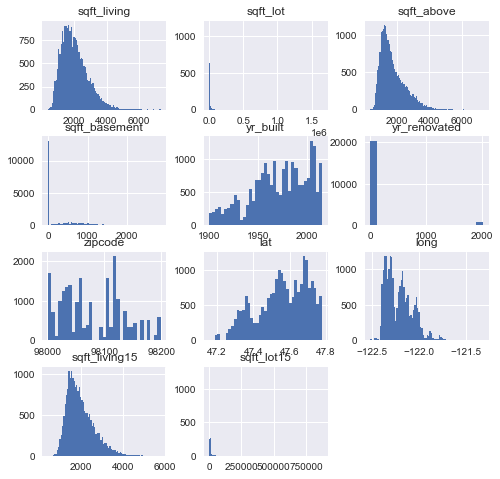

In [116]:
# df_cont.hist(figsize=(8,8), bins='auto');

In [117]:
# def normalize(X):
#     normalized = (X - np.mean(X)) / np.sqrt(np.var(X))
#     return normalized

# scaled_features = df_cont.apply(normalize)

array([[<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_above'}>],
       [<AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>],
       [<AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>],
       [<AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>, <AxesSubplot:>]],
      dtype=object)

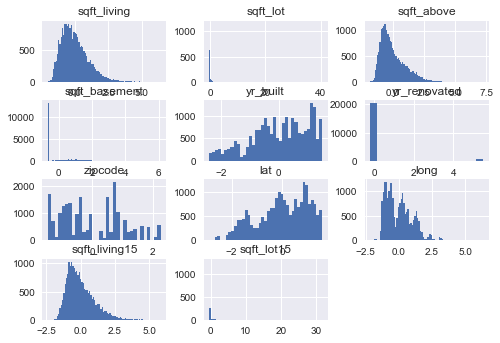

In [118]:
# scaled_features.hist(bins='auto')

In [132]:
# cols_to_drop = scaled_features.columns
# cols_to_drop

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [133]:
# df_new_3.drop(columns=cols_to_drop, inplace=True)

In [134]:
# df_final = pd.concat([scaled_features, df_new_3], axis=1)

In [120]:
# replacement for standardizing

df_final = df_new_3

In [121]:
df_final

,id,date,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,...,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipco_98051_to_98100,zipco_98101_to_98150,zipco_98150_to_98200
0,7129300520,2014-10-13,221900.0,1180,5650,1180,0.0,1955,0.0,47.5112,...,0,1,0,0,0,0,0,0,0,1
1,6414100192,2014-12-09,538000.0,2570,7242,2170,400.0,1951,1991.0,47.7210,...,0,1,0,0,0,0,0,0,1,0
2,5631500400,2015-02-25,180000.0,770,10000,770,0.0,1933,0.0,47.7379,...,1,0,0,0,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,1960,5000,1050,910.0,1965,0.0,47.5208,...,0,1,0,0,0,0,0,0,1,0
4,1954400510,2015-02-18,510000.0,1680,8080,1680,0.0,1987,0.0,47.6168,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,1530,1131,1530,0.0,2009,0.0,47.6993,...,0,0,1,0,0,0,0,0,1,0
21593,6600060120,2015-02-23,400000.0,2310,5813,2310,0.0,2014,0.0,47.5107,...,0,0,1,0,0,0,0,0,1,0
21594,1523300141,2014-06-23,402101.0,1020,1350,1020,0.0,2009,0.0,47.5944,...,0,1,0,0,0,0,0,0,1,0
21595,291310100,2015-01-16,400000.0,1600,2388,1600,0.0,2004,0.0,47.5345,...,0,0,1,0,0,0,0,0,0,0


In [122]:
df_final.columns

Index(['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'bedro_2', 'bedro_3', 'bedro_4',
       'bedro_5', 'bedro_6', 'bedro_7', 'bedro_8', 'bedro_9', 'bedro_10',
       'bedro_11', 'bedro_33', 'bathr_1_to_2', 'bathr_2_to_3', 'bathr_3_to_4',
       'bathr_4_to_5', 'bathr_5_to_6', 'bathr_6_plus', 'floor_1.5',
       'floor_2.0', 'floor_2.5', 'floor_3.0', 'floor_3.5', 'water_1.0',
       'view_1.0', 'view_2.0', 'view_3.0', 'view_4.0', 'condi_2', 'condi_3',
       'condi_4', 'condi_5', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12',
       'zipco_98051_to_98100', 'zipco_98101_to_98150', 'zipco_98150_to_98200'],
      dtype='object')

### Check for Multicollinearity

In [123]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_pairs=df_final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_pairs['pairs'] = list(zip(df_pairs.level_0, df_pairs.level_1))

# set index to pairs
df_pairs.set_index(['pairs'], inplace = True)

#d rop level columns
df_pairs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_pairs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_pairs.drop_duplicates(inplace=True)

In [124]:
df_pairs[(df_pairs.cc>.75) & (df_pairs.cc <1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.863153
"(condi_3, condi_4)",0.814175
"(sqft_living15, sqft_living)",0.751785


Based on this correlation information, it looks like sqft_living should be dropped as a variable, as it is correlated to both sqft_above and sqft_living15.

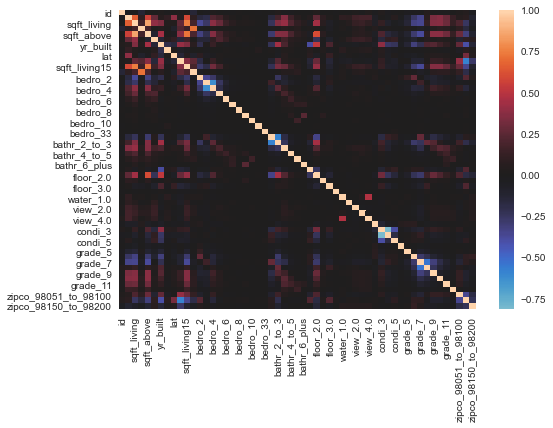

In [125]:
sns.heatmap(df_final.corr(), center=0);

In [126]:
df_final.drop('sqft_living', inplace=True, axis=1)

In [127]:
df_final

,id,date,price,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,...,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipco_98051_to_98100,zipco_98101_to_98150,zipco_98150_to_98200
0,7129300520,2014-10-13,221900.0,5650,1180,0.0,1955,0.0,47.5112,-122.257,...,0,1,0,0,0,0,0,0,0,1
1,6414100192,2014-12-09,538000.0,7242,2170,400.0,1951,1991.0,47.7210,-122.319,...,0,1,0,0,0,0,0,0,1,0
2,5631500400,2015-02-25,180000.0,10000,770,0.0,1933,0.0,47.7379,-122.233,...,1,0,0,0,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,5000,1050,910.0,1965,0.0,47.5208,-122.393,...,0,1,0,0,0,0,0,0,1,0
4,1954400510,2015-02-18,510000.0,8080,1680,0.0,1987,0.0,47.6168,-122.045,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,1131,1530,0.0,2009,0.0,47.6993,-122.346,...,0,0,1,0,0,0,0,0,1,0
21593,6600060120,2015-02-23,400000.0,5813,2310,0.0,2014,0.0,47.5107,-122.362,...,0,0,1,0,0,0,0,0,1,0
21594,1523300141,2014-06-23,402101.0,1350,1020,0.0,2009,0.0,47.5944,-122.299,...,0,1,0,0,0,0,0,0,1,0
21595,291310100,2015-01-16,400000.0,2388,1600,0.0,2004,0.0,47.5345,-122.069,...,0,0,1,0,0,0,0,0,0,0


In [128]:
df_final.to_csv("data/housing_data_clean.csv", index=False)